In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [3]:
# Read the files that we need

dataunits = pd.read_csv('data/BrandTotalUnits.csv')
datasales = pd.read_csv('data/BrandTotalSales.csv')
dataapr = pd.read_csv('data/BrandAverageRetailPrice.csv')
branddetails = pd.read_csv('data/BrandDetails.csv')

In [4]:
# change data types

dataunits['Months'] = pd.to_datetime(dataunits['Months'])
dataunits['Total Units'] = dataunits['Total Units'].str.replace(',', '')
dataunits['Total Units'] = dataunits['Total Units'].str[:8]
dataunits['Total Units'] = pd.to_numeric(dataunits['Total Units'])
#dataunits['Total Units'] = dataunits['Total Units'].fillna(0)

In [5]:
dataunits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Brands            27686 non-null  object        
 1   Months            27686 non-null  datetime64[ns]
 2   Total Units       25712 non-null  float64       
 3   vs. Prior Period  24935 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 865.3+ KB


In [6]:
# change data types

datasales['Months'] = pd.to_datetime(datasales['Months'])
datasales['Total Sales ($)'] = datasales['Total Sales ($)'].str.replace(',', '')
datasales['Total Sales ($)'] = datasales['Total Sales ($)'].str[:8]
datasales['Total Sales ($)'] = pd.to_numeric(datasales['Total Sales ($)'])

In [7]:
datasales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


In [8]:
# change data types

dataapr['Months'] = pd.to_datetime(dataunits['Months'])

In [9]:
dataapr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27211 entries, 0 to 27210
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Brands            27211 non-null  object        
 1   Months            27211 non-null  datetime64[ns]
 2   ARP               25279 non-null  float64       
 3   vs. Prior Period  24499 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 850.5+ KB


In [10]:
dataunits = dataunits.merge(datasales, how='outer', left_on=["Brands","Months"], right_on=["Brand","Months"])
dataunits = dataunits.drop(['Brand'], axis = 1)

# Fill the missing value with mean of each brand
dataunits['Total Units'] = dataunits.groupby("Brands")["Total Units"].transform(lambda x: x.fillna(x.mean()))
dataunits['Total Sales ($)'] = dataunits.groupby("Brands")["Total Sales ($)"].transform(lambda x: x.fillna(x.mean()))
dataunits["ARP"] = dataunits["Total Sales ($)"]/dataunits["Total Units"]
dataunits['Year'] = pd.DatetimeIndex(dataunits['Months']).year
dataunits['Month'] = pd.DatetimeIndex(dataunits['Months']).month
dataunits["Product Count"] = 0
dataunits['Rolling Average'] = 0
dataunits['Aggregate Sales'] = 0

# Add L1 features
dataunits["Ingestibles"] = 0
dataunits["Inhaleables"] = 0
dataunits["All accessories"] = 0
dataunits["Other Cannabis"] = 0
dataunits["Topicals"] = 0

# Add L2 features
dataunits['Concentrates'] = 0
dataunits["Pre-Rolled"] = 0
dataunits["Flower"] = 0
dataunits["Edibles"] = 0
dataunits["Sublinguals"] = 0
dataunits["Other Cannabis_L2"] = 0
dataunits['Topicals_L2'] = 0
dataunits["Devices"] = 0
dataunits["Shake/Trim/Lite"] = 0
dataunits["Accessories"] = 0
dataunits["Apparel"] = 0
dataunits["Non Infused Food"] = 0
dataunits["Grow Supplies"] = 0

value = 0

# Length in market of the brand
dataunits['Length_'] = dataunits.groupby('Brands')['Months'].diff().dt.days.fillna(0).astype(int)
dataunits['Length'] = dataunits.groupby(['Brands'])['Length_'].cumsum()
dataunits['Length'] = dataunits['Length'] // 30
dataunits.drop('Length_', axis=1, inplace=True)

# for-loop to calculate new features that we will add
brands = dataunits["Brands"].unique()
for brand in brands:
    dataunits['Rolling Average'].loc[dataunits["Brands"] == brand] = (dataunits[dataunits.Brands == brand].loc[:,'Total Units'].shift(1) + dataunits[dataunits.Brands == brand].loc[:,'Total Units'].shift(2) + dataunits[dataunits.Brands == brand].loc[:,'Total Units'])/3
    dataunits['Aggregate Sales'].loc[dataunits["Brands"] == brand] = dataunits[dataunits.Brands == brand].loc[:,'Total Sales ($)'].shift(1) + dataunits[dataunits.Brands == brand].loc[:,'Total Sales ($)'].shift(2) + dataunits[dataunits.Brands == brand].loc[:,'Total Sales ($)']
    dataunits["Product Count"].loc[dataunits["Brands"] == brand] = branddetails[branddetails.Brand == brand].Brand.count()
    dataunits['Total Units'].loc[dataunits["Brands"] == brand] = dataunits['Total Units'].loc[dataunits["Brands"] == brand].fillna(value = dataunits['Total Units'].loc[dataunits["Brands"] == brand].mean())
    
    # check L1 features
    if 'Inhaleables' in branddetails[branddetails.Brand == brand]['Category L1'].values:
        value = 1
    dataunits["Inhaleables"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Ingestibles' in branddetails[branddetails.Brand == brand]['Category L1'].values:
        value = 1
    dataunits["Ingestibles"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'All accessories' in branddetails[branddetails.Brand == brand]['Category L1'].values:
        value = 1
    dataunits["All accessories"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Other Cannabis' in branddetails[branddetails.Brand == brand]['Category L1'].values:
        value = 1
    dataunits["Other Cannabis"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Topicals' in branddetails[branddetails.Brand == brand]['Category L1'].values:
        value = 1
    dataunits["Topicals"].loc[dataunits["Brands"] == brand] = value
    value = 0
    
    
    # check L2 features
    if 'Concentrates' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Concentrates"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Pre-Rolled' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Pre-Rolled"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Flower' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Flower"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Edibles' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Edibles"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Sublinguals' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Sublinguals"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Other Cannabis' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Other Cannabis_L2"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Topicals' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Topicals_L2"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Devices' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Devices"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Shake/Trim/Lite' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Shake/Trim/Lite"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Accessories' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Accessories"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Apparel' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Apparel"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Non Infused Food' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Non Infused Food"].loc[dataunits["Brands"] == brand] = value
    value = 0
    if 'Grow Supplies' in branddetails[branddetails.Brand == brand]['Category L2'].values:
        value = 1
    dataunits["Grow Supplies"].loc[dataunits["Brands"] == brand] = value
    value = 0
    
    


#dataunits = dataunits.drop(["Months"],axis=1)
#dataunits = dataunits.drop(["vs. Prior Period_y"],axis=1)



C:\Users\ericz\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
# Fill null with the mean value, grouby the brands

dataunits['Rolling Average'] = dataunits.groupby("Brands")["Rolling Average"].transform(lambda x: x.fillna(x.mean()))
dataunits['Aggregate Sales'] = dataunits.groupby("Brands")["Aggregate Sales"].transform(lambda x: x.fillna(x.mean()))

In [12]:
dataunits.head(20)

,Brands,Months,Total Units,vs. Prior Period,Total Sales ($),ARP,Year,Month,Product Count,Rolling Average,...,Sublinguals,Other Cannabis_L2,Topicals_L2,Devices,Shake/Trim/Lite,Accessories,Apparel,Non Infused Food,Grow Supplies,Length
0,#BlackSeries,2020-08-01,1616.339000,NaN,25352.130000,15.684909,2020,8,4,932.757389,...,0,0,0,0,0,0,0,0,0,0
1,#BlackSeries,2020-09-01,1032.846967,-1.000000,14731.451667,14.262957,2020,9,4,932.757389,...,0,0,0,0,0,0,0,0,0,1
2,#BlackSeries,2021-01-01,715.532800,NaN,9739.423000,13.611428,2021,1,4,1121.572922,...,0,0,0,0,0,0,0,0,0,5
3,#BlackSeries,2021-02-01,766.669100,0.071466,9102.802000,11.873182,2021,2,4,838.349622,...,0,0,0,0,0,0,0,0,0,6
4,#BlackSeries,2021-03-01,1032.846967,-1.000000,14731.451667,14.262957,2021,3,4,838.349622,...,0,0,0,0,0,0,0,0,0,7
5,101 Cannabis Co.,2019-11-01,131.067700,NaN,4465.040000,34.066669,2019,11,77,585.324868,...,0,0,0,0,0,0,0,0,0,0
6,101 Cannabis Co.,2019-12-01,566.557827,-1.000000,18276.247000,32.258396,2019,12,77,585.324868,...,0,0,0,0,0,0,0,0,0,1
7,101 Cannabis Co.,2020-01-01,345.413400,NaN,11790.660000,34.134924,2020,1,77,347.679642,...,0,0,0,0,0,0,0,0,0,2
8,101 Cannabis Co.,2020-02-01,696.658400,1.016883,20266.760000,29.091388,2020,2,77,536.209876,...,0,0,0,0,0,0,0,0,0,3
9,101 Cannabis Co.,2020-03-01,943.393300,0.354169,30465.470000,32.293498,2020,3,77,661.821700,...,0,0,0,0,0,0,0,0,0,4


Total Sales ($)      1.000000
Aggregate Sales      0.991939
Total Units          0.873737
Rolling Average      0.870348
Product Count        0.504025
Devices              0.161291
Inhaleables          0.133795
Concentrates         0.128036
Other Cannabis_L2    0.114537
Other Cannabis       0.114537
Length               0.112535
Edibles              0.098954
Ingestibles          0.090269
Flower               0.089698
Pre-Rolled           0.078196
Sublinguals          0.074772
Topicals             0.062194
Topicals_L2          0.062194
Apparel              0.032085
Grow Supplies        0.032085
Non Infused Food     0.023848
Shake/Trim/Lite      0.005336
Month                0.003241
ARP                  0.002643
vs. Prior Period    -0.009732
Year                -0.010916
Accessories         -0.023692
All accessories           NaN
Name: Total Sales ($), dtype: float64


array([[<AxesSubplot:xlabel='Total Units', ylabel='Total Units'>,
        <AxesSubplot:xlabel='vs. Prior Period', ylabel='Total Units'>,
        <AxesSubplot:xlabel='Rolling Average', ylabel='Total Units'>,
        <AxesSubplot:xlabel='Aggregate Sales', ylabel='Total Units'>,
        <AxesSubplot:xlabel='ARP', ylabel='Total Units'>],
       [<AxesSubplot:xlabel='Total Units', ylabel='vs. Prior Period'>,
        <AxesSubplot:xlabel='vs. Prior Period', ylabel='vs. Prior Period'>,
        <AxesSubplot:xlabel='Rolling Average', ylabel='vs. Prior Period'>,
        <AxesSubplot:xlabel='Aggregate Sales', ylabel='vs. Prior Period'>,
        <AxesSubplot:xlabel='ARP', ylabel='vs. Prior Period'>],
       [<AxesSubplot:xlabel='Total Units', ylabel='Rolling Average'>,
        <AxesSubplot:xlabel='vs. Prior Period', ylabel='Rolling Average'>,
        <AxesSubplot:xlabel='Rolling Average', ylabel='Rolling Average'>,
        <AxesSubplot:xlabel='Aggregate Sales', ylabel='Rolling Average'>,
        <A

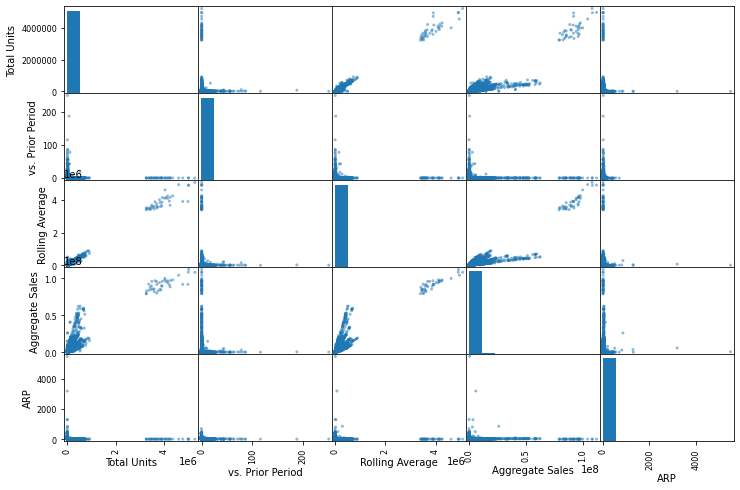

In [13]:
# Correlation with features and label

from pandas.plotting import scatter_matrix
corr_matrix = dataunits.corr()
print(corr_matrix["Total Sales ($)"].sort_values(ascending=False))
attributes = ["Total Units", "vs. Prior Period", "Rolling Average", 
             "Aggregate Sales", "ARP"]
scatter_matrix(dataunits[attributes], figsize=(12, 8))
#save_fig("correlation_matrix")

In [14]:
#data = dataunits.loc[dataunits["Total Sales ($)"] < 100000].copy()
#data = data.loc[data["Total Sales ($)"] > 50000].copy()

# save a copy to use
data = dataunits.copy()

In [15]:
data.head()

,Brands,Months,Total Units,vs. Prior Period,Total Sales ($),ARP,Year,Month,Product Count,Rolling Average,...,Sublinguals,Other Cannabis_L2,Topicals_L2,Devices,Shake/Trim/Lite,Accessories,Apparel,Non Infused Food,Grow Supplies,Length
0,#BlackSeries,2020-08-01,1616.339000,NaN,25352.130000,15.684909,2020,8,4,932.757389,...,0,0,0,0,0,0,0,0,0,0
1,#BlackSeries,2020-09-01,1032.846967,-1.000000,14731.451667,14.262957,2020,9,4,932.757389,...,0,0,0,0,0,0,0,0,0,1
2,#BlackSeries,2021-01-01,715.532800,NaN,9739.423000,13.611428,2021,1,4,1121.572922,...,0,0,0,0,0,0,0,0,0,5
3,#BlackSeries,2021-02-01,766.669100,0.071466,9102.802000,11.873182,2021,2,4,838.349622,...,0,0,0,0,0,0,0,0,0,6
4,#BlackSeries,2021-03-01,1032.846967,-1.000000,14731.451667,14.262957,2021,3,4,838.349622,...,0,0,0,0,0,0,0,0,0,7


In [16]:
# drop label and non-necessary features

data_label = data["Total Sales ($)"].copy()
data = data.drop("Total Sales ($)", axis=1)
data = data.drop("Months",axis=1)
data = data.drop("Brands",axis=1)


In [17]:
data.head(5)

,Total Units,vs. Prior Period,ARP,Year,Month,Product Count,Rolling Average,Aggregate Sales,Ingestibles,Inhaleables,...,Sublinguals,Other Cannabis_L2,Topicals_L2,Devices,Shake/Trim/Lite,Accessories,Apparel,Non Infused Food,Grow Supplies,Length
0,1616.339000,NaN,15.684909,2020,8,4,932.757389,38990.119333,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1032.846967,-1.000000,14.262957,2020,9,4,932.757389,38990.119333,0,1,...,0,0,0,0,0,0,0,0,0,1
2,715.532800,NaN,13.611428,2021,1,4,1121.572922,49823.004667,0,1,...,0,0,0,0,0,0,0,0,0,5
3,766.669100,0.071466,11.873182,2021,2,4,838.349622,33573.676667,0,1,...,0,0,0,0,0,0,0,0,0,6
4,1032.846967,-1.000000,14.262957,2021,3,4,838.349622,33573.676667,0,1,...,0,0,0,0,0,0,0,0,0,7


In [18]:
# label encoder

from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 
  
data_label = le.fit_transform(data_label) 
data_label

array([9167, 6907, 5402, ..., 6159, 3450, 5860], dtype=int64)

In [19]:
# The pipeline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin


imputer = SimpleImputer(strategy="median")
data_num = data.drop(["Ingestibles", "Inhaleables", "All accessories", "Other Cannabis", "Topicals","Year", "Month",
                     "Flower", 'Concentrates', 'Pre-Rolled', 'Topicals_L2', 'Edibles', 'Devices', 'Sublinguals',
                     'Other Cannabis_L2', 'Accessories', 'Non Infused Food', 'Apparel', 'Grow Supplies', 'Shake/Trim/Lite'], axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

data_num_tr = num_pipeline.fit_transform(data_num)
numerical_features = list(data_num)
categorical_features = ["Ingestibles", "Inhaleables", "All accessories", "Other Cannabis", "Topicals","Year", "Month",
                     "Flower", 'Concentrates', 'Pre-Rolled', 'Topicals_L2', 'Edibles', 'Devices', 'Sublinguals',
                     'Other Cannabis_L2', 'Accessories', 'Non Infused Food', 'Apparel', 'Grow Supplies', 'Shake/Trim/Lite']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(sparse=False, categories='auto'), categorical_features),
    ])

data_prepared = full_pipeline.fit_transform(data)

print(data_prepared)

[[-0.16241267 -0.09237606 -0.1664302  ...  0.          1.
   0.        ]
 [-0.16611303 -0.39470865 -0.19734558 ...  0.          1.
   0.        ]
 [-0.16812535 -0.09237606 -0.21151081 ...  0.          1.
   0.        ]
 ...
 [-0.17045579 -0.15482569  0.24364159 ...  0.          1.
   0.        ]
 [-0.1718011  -0.2697429   0.29373115 ...  0.          1.
   0.        ]
 [-0.17066416 -0.39470865  0.2596952  ...  0.          1.
   0.        ]]


In [20]:
# data split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_prepared, data_label, test_size = 0.15, random_state=200)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23533, 58)
(4153, 58)
(23533,)
(4153,)


In [21]:
# Fit into Linear Regression
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


y_pred = lin_reg.predict(X_test)

In [22]:
regression_results(y_test, y_pred)

explained_variance:  0.4658
mean_squared_log_error:  0.846
r2:  0.4656
MAE:  4641.7202
MSE:  31730701.2584
RMSE:  5633.0011


In [23]:
# check p-value, F stats and T stats

import statsmodels.api as sm
stats = sm.OLS(data_label, data_prepared)
results_stats = stats.fit()

print(results_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     643.5
Date:                Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                        02:02:47   Log-Likelihood:            -2.7849e+05
No. Observations:               27686   AIC:                         5.570e+05
Df Residuals:                   27650   BIC:                         5.573e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3838.4298    295.734     12.979      0.0

In [24]:
data_prepared.shape

(27686, 58)

In [25]:
# try to use PCA to reduce dimension

from sklearn import decomposition

pca = decomposition.PCA(n_components=5)

data_pca = pca.fit_transform(data_prepared)

In [26]:
data_pca.shape

(27686, 5)

In [27]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(data_pca, data_label, test_size=0.15)

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(new_X_train, new_y_train)

new_y_pred = lin_reg.predict(new_X_test)


In [29]:
regression_results(new_y_test, new_y_pred)

explained_variance:  0.2986
mean_squared_log_error:  0.9764
r2:  0.2985
MAE:  5434.2317
MSE:  41386407.6749
RMSE:  6433.2268


In [30]:
# Use Gradient Boosting as the ensemble method

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor


est = GradientBoostingRegressor(
    n_estimators=100, learning_rate=1, max_depth=1, random_state=100).fit(X_train, y_train)

y_pred = est.predict(X_test)


explained_variance=metrics.explained_variance_score(y_test, y_pred)
mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
mse=metrics.mean_squared_error(y_test, y_pred) 
median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
r2=metrics.r2_score(y_test, y_pred)
print('explained_variance: ', round(explained_variance,4))    
print('r2: ', round(r2,4))
print('MAE: ', round(mean_absolute_error,4))
print('MSE: ', round(mse,4))
print('RMSE: ', round(np.sqrt(mse),4))

explained_variance:  0.9761
r2:  0.9761
MAE:  749.8474
MSE:  1419207.9922
RMSE:  1191.3052


In [31]:
# Grid Search(Gradient Boosting) and 10-fold CV

from sklearn.model_selection import GridSearchCV

param_grid={'learning_rate': [0.1,1,10]}

estimator = GradientBoostingRegressor(n_estimators=100, random_state=100) 
grid = GridSearchCV(estimator=estimator, cv=10, scoring='neg_mean_absolute_error', param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

In [32]:
print('Best Score:', grid_result.best_score_)

Best Score: -389.69814766295246


In [33]:
print('Best Params: ', grid_result.best_params_)

Best Params:  {'learning_rate': 0.1}


In [34]:
# Grid Search(Lasso) and 10-fold CV

from sklearn.linear_model import Lasso
# Train model with default alpha=1
lasso = Lasso(alpha=1).fit(X_train, y_train)
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 1000000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   23.3s finished


Best Score:  -4662.274807469377
Best Params:  {'alpha': 0.001}


C:\Users\ericz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13857921952.223877, tolerance: 135842029.44131684
  model = cd_fast.enet_coordinate_descent(


In [35]:
# Grid Search(Ridge) and 10-fold CV

from sklearn.linear_model import Ridge
# Train model with default alpha=1
ridge = Ridge(alpha=1).fit(X_train, y_train)
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 1000000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.5s finished


Best Score:  -4662.2735967388635
Best Params:  {'alpha': 0.001}


In [36]:
# fit data into Multi-layer Regression

from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(solver='adam', alpha=1, max_iter=500, random_state=200).fit(X_train, y_train)
MLP_y_pred = regr.predict(X_test)

C:\Users\ericz\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [37]:
regression_results(y_test, MLP_y_pred)

explained_variance:  0.8527
mean_squared_log_error:  0.4863
r2:  0.8527
MAE:  2187.9613
MSE:  8747441.4188
RMSE:  2957.6074
